# **Project 1: Pizza Sales Analysis**

## **Problem Statement**

### **Business Context**

A moderately sized, locally popular food joint operates a chain of outlets located in a metropolitan area, offering a diverse menu of pizzas, sides, and beverages. Despite having a steady flow of customers, they face challenges in optimizing their order fulfillment process, leading to delays during peak hours, which results in customer dissatisfaction and impacts repeat business. Additionally, they struggle with inventory management, often experiencing shortages of popular ingredients or excess stock of less favored items. To address these issues, they are implementing a new order management system and seeking to analyze sales data to better predict demand and streamline inventory.

### **Objective**

You have been engaged by the business as a Data Analyst to enhance operational efficiency and boost customer satisfaction. You have been provided with raw historical sales data and tasked with pre-processing historical sales data to uncover trends, building an interactive dashboard to enable visual reporting of key metrics, and generating email reports to communicate key insights to stakeholders. This will enable the stakeholders to get a clearer understanding of the business, stay on top of changing market scenarios via frequent alerts, and make quick, informed decisions to resolve operational challenges. The anticipated outcomes include reduced order processing times, improved inventory turnover, and increased customer satisfaction leading to higher repeat sales.

### **Data Description:**

This dataset contain detailed information about pizza orders, including specifics about the pizza variants, quantities, pricing, dates, times, and categorization details.
- **pizza_id:** A unique identifier assigned to each distinct pizza variant available for ordering.  
- **order_id:** A unique identifier for each order made, which links to multiple pizzas.  
- **pizza_name_id:** An identifier linking to a specific name of the pizza.  
- **quantity:** The number of units of a specific pizza variant ordered within an order.  
- **order_date:** The date when the order was placed.  
- **order_time:** The time when the order was placed.  
- **unit_price:** The cost of a single unit of the specific pizza variant.  
- **pizza_size:** Represents the size of the pizza (e.g., small, medium, large).  
- **pizza_category:** Indicates the category of the pizza, such as vegetarian, non-vegetarian, etc.  
- **pizza_name:** Specifies the name of the specific pizza variant ordered.  

## **AzureML Setup and Data Loading**

### **Connect to Azure Machine Learning Workspace**

In [6]:
# Connect to AzureML workspace
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
credential = DefaultAzureCredential()

In [ ]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="######################",
    resource_group_name="##############",
    workspace_name="#############",
)

### **Create Compute Cluster**

In [8]:
from azure.ai.ml.entities import AmlCompute

# Connecting to the compute cluster called test-cluster
cpu_compute_target = "test-cluster"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="Standard_A2_v2",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=1,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )

    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster).result()

print(
    f"AMLCompute with name {cpu_cluster.name} is created, the compute size is {cpu_cluster.size}"
)

You already have a cluster named test-cluster, we'll reuse it as is.
AMLCompute with name test-cluster is created, the compute size is Standard_A2_v2


### **Register Dataset into Data Assets**

In [9]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

local_data_path = 'pizza_sales.csv'

data_asset = Data(
    path=local_data_path,
    type=AssetTypes.URI_FILE, 
    description="A dataset of pizza sales",
    name="pizza-data-sales"
)

ml_client.data.create_or_update(data_asset)

Data({'path': 'azureml://subscriptions/fd4f3459-3769-40ac-b8d1-05f49844d781/resourcegroups/gl-dec24-pro/workspaces/FitwellWorkspace/datastores/workspaceblobstore/paths/LocalUpload/c1e3841d1aef92e0b27bbe4cf1e978e7/pizza_sales.csv', 'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'pizza-data-sales', 'description': 'A dataset of pizza sales', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/fd4f3459-3769-40ac-b8d1-05f49844d781/resourceGroups/gl-dec24-pro/providers/Microsoft.MachineLearningServices/workspaces/FitwellWorkspace/data/pizza-data-sales/versions/5', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/analysisprojectweek6/code/Users/Juan-Jos_1736617439923/Project', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7fdc227e6530>, 'serialize': <msr

### **Create a Job Environment**

In [10]:
import os
project_env = "./project_env"
os.makedirs(project_env, exist_ok=True)

In [11]:
%%writefile {project_env}/conda.yml
name: sklearn-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - pip=21.2.4
  - scikit-learn=0.23.2
  - scipy=1.7.1
  - pip:  
    - mlflow==2.8.1
    - azureml-mlflow==1.51.0
    - azureml-inference-server-http
    - azureml-core==1.57.0
    - cloudpickle==1.6.0
    - huggingface_hub
    - datasets
    - seaborn
    - pandas

Overwriting ./project_env/conda.yml


In [12]:
from azure.ai.ml.entities import Environment, BuildContext

env_docker_conda = Environment(
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04",
    conda_file="project_env/conda.yml",
    name="project-sales-pizza",
    description="Environment created from a Docker image plus Conda environment.",
)
ml_client.environments.create_or_update(env_docker_conda)

Environment({'arm_type': 'environment_version', 'latest_version': None, 'image': 'mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04', 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'project-sales-pizza', 'description': 'Environment created from a Docker image plus Conda environment.', 'tags': {}, 'properties': {'azureml.labels': 'latest'}, 'print_as_yaml': False, 'id': '/subscriptions/fd4f3459-3769-40ac-b8d1-05f49844d781/resourceGroups/gl-dec24-pro/providers/Microsoft.MachineLearningServices/workspaces/FitwellWorkspace/environments/project-sales-pizza/versions/7', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/analysisprojectweek6/code/Users/Juan-Jos_1736617439923/Project', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7fdc1d56e350>, 'serialize': <msrest.serialization.Serializer object at 0x7fdc1d56e410>, 'version': '7', 'conda_file':

**On the previous cells, the following steps has been done:**

1. Connect to ML Azure Workspace with subscription_id and resource_group.
2. Create a compute cluster named "test-cluster" which will be used for execute the pipeline.
3. Upload a Data Asset with pizza_sales.csv info.
4. Create a .yml with dependencies for Environment created for run "project-sales-pizza".

## Exploratory Data Analysis

### **Data Overview**

In [13]:
%pip install seaborn #### why didn't work wit !pip install seaborn?

Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data_sales = pd.read_csv('pizza_sales.csv')
data_sales.head(5)

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1.0,1.0,hawaiian_m,1.0,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2.0,2.0,classic_dlx_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3.0,2.0,five_cheese_l,1.0,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4.0,2.0,ital_supr_l,1.0,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5.0,2.0,mexicana_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [17]:
# get the shape of the data
data_sales.shape

(48620, 12)

In [18]:
# get the info of the data
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  float64
 1   order_id           48620 non-null  float64
 2   pizza_name_id      48620 non-null  object 
 3   quantity           48620 non-null  float64
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48620 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48620 non-null  object 
 10  pizza_ingredients  48620 non-null  object 
 11  pizza_name         48620 non-null  object 
dtypes: float64(5), object(7)
memory usage: 4.5+ MB


In [56]:
# generate the statistical summary of the dataset
data_sales.describe().T

,count,mean,std,min,25%,50%,75%,max
pizza_id,48620.0,24310.500000,14035.529381,1.00,12155.75,24310.5,36465.25,48620.00
order_id,48620.0,10701.479761,6180.119770,1.00,5337.00,10682.5,16100.00,21350.00
quantity,48620.0,1.019622,0.143077,1.00,1.00,1.0,1.00,4.00
unit_price,48620.0,16.494132,3.621789,9.75,12.75,16.5,20.25,35.95
total_price,48620.0,16.821474,4.437398,9.75,12.75,16.5,20.50,83.00


In [25]:
# calculate the sum of duplicated values
data_sales.duplicated().sum()

0

In [26]:
# check for any missing values
data_sales.isnull().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

1.	There are not missing values or duplicated values on this database.
2.	There is a mean of one pizza per order, but the 75% of the clients bought only one pizza.
3.	The average and standar deviation of the unit price are 16.49 and 3.62 respectively. The median is equal to 16.50, therefore, the distribution has no trend skewed. Something similar happen with total_price, where the Max Value of this propertie could be represented by an outlier.


In [27]:
df = data_sales.copy()

### **Univariate Analysis**

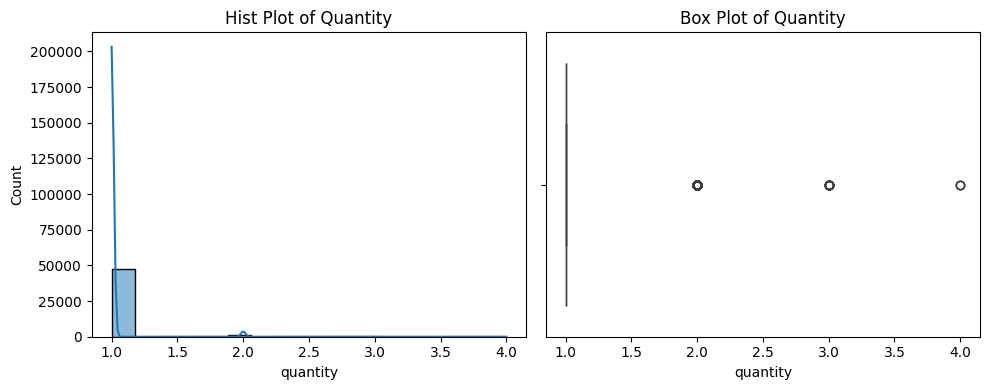

In [28]:
#write your code here
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.histplot(data=df, x='quantity', kde=True, ax=axes[0])
axes[0].set_title("Hist Plot of Quantity")
# plt.show()
sns.boxplot(data=df,x='quantity',ax=axes[1])
axes[1].set_title("Box Plot of Quantity")
plt.tight_layout()
plt.show()


1. The distribution is skewed towards right.
2. There are not many outliers present in this column.

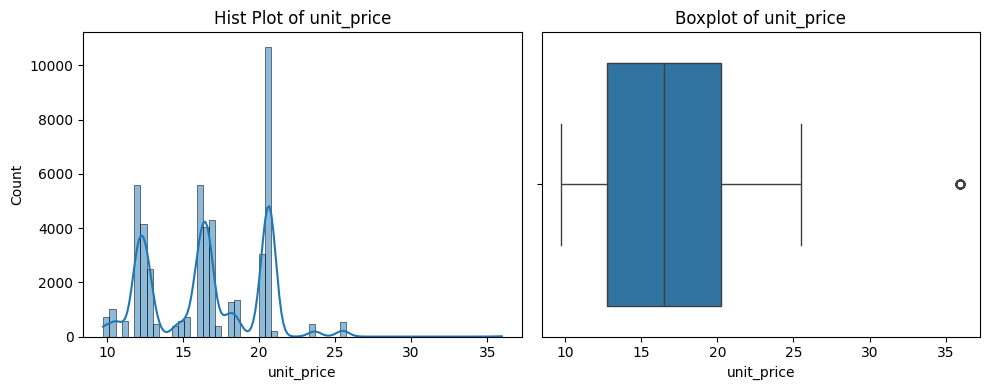

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.histplot(data=df, x='unit_price', kde=True, ax=axes[0])
axes[0].set_title("Hist Plot of unit_price")
sns.boxplot(data=df,x='unit_price', ax=axes[1])
axes[1].set_title("Boxplot of unit_price")
plt.tight_layout()
plt.show()


1. The distribution is skewed towards right.
2. The unit price is three modal propertie.

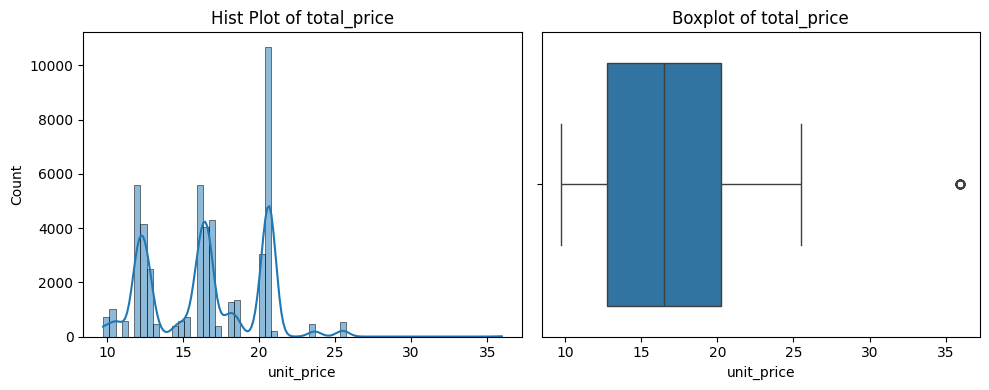

In [144]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.histplot(data=df, x='unit_price', kde=True, ax=axes[0])
axes[0].set_title("Hist Plot of total_price")
sns.boxplot(data=df,x='unit_price', ax=axes[1])
axes[1].set_title("Boxplot of total_price")
plt.tight_layout()
plt.show()

1. The distribution is skewed towards right.
2. The total price is three modal property, same as unit price.
3. **The data presented will not be considered as outlier because are values which could represent real sales**

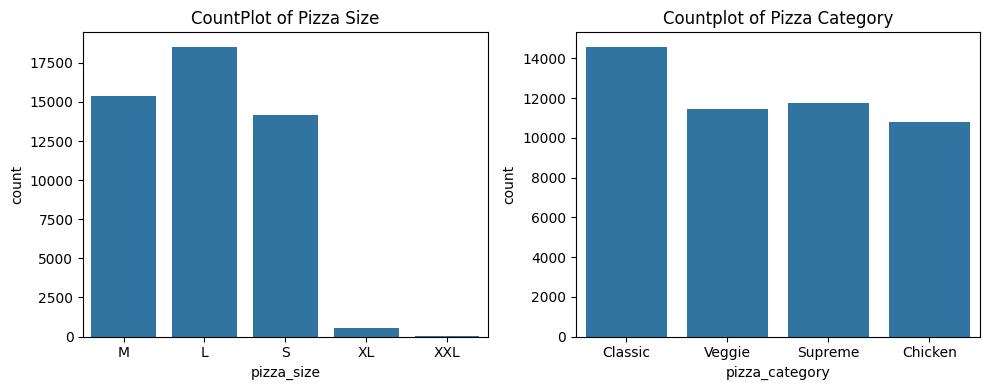

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.countplot(data=df, x='pizza_size', ax=axes[0])
axes[0].set_title("CountPlot of Pizza Size")
sns.countplot(data=df, x='pizza_category', ax=axes[1])
axes[1].set_title("Countplot of Pizza Category")
plt.tight_layout()
plt.show()

1. The most pizza size delivered is L sized. Followed by M and then S.
2. The most category chosen by customer is Classic.
3. The total orders are dividen between 32 kind of Pizzas.

In [30]:
df['pizza_name'].nunique()

32

### **Feature Engineering**

Write a code to convert the order_date and order_time columns into a single order_time column in datetime format, and then drop the original order_date column from the dataframe. Finally, display the first few rows of the modified dataframe.

In [31]:
# Write your code here
df['order_date']  = pd.to_datetime(df['order_date'])
df['order_time'] = df['order_date'].astype(str)+' '+df['order_time'].astype(str)
df['order_time']  = pd.to_datetime(df['order_time'])
df.drop('order_date',axis=1,inplace=True)
df

,pizza_id,order_id,pizza_name_id,quantity,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1.0,1.0,hawaiian_m,1.0,2015-01-01 11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2.0,2.0,classic_dlx_m,1.0,2015-01-01 11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3.0,2.0,five_cheese_l,1.0,2015-01-01 11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4.0,2.0,ital_supr_l,1.0,2015-01-01 11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5.0,2.0,mexicana_m,1.0,2015-01-01 11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
...,...,...,...,...,...,...,...,...,...,...,...
48615,48616.0,21348.0,ckn_alfredo_m,1.0,2015-12-31 21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza
48616,48617.0,21348.0,four_cheese_l,1.0,2015-12-31 21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
48617,48618.0,21348.0,napolitana_s,1.0,2015-12-31 21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
48618,48619.0,21349.0,mexicana_l,1.0,2015-12-31 22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


Write a code snippet to extract the month from the order_time column and create a new column called order_month. Additionally, classify the order_time into different parts of the day (Morning, Afternoon, Evening) based on the hour and store this information in a new column called time_of_day. Finally, display the first few rows of the modified dataframe.

In [32]:
df['order_month'] = df['order_time'].dt.month
df['order_month']

def category_day(x):
    if 0 < x <= 6:
        return 'Evening'
    elif 6 < x <= 13:
        return 'Morning'
    elif 13 < x <= 20:
        return 'Afternoon'
    else:
        return 'Evening'

df['time_of_day'] = df['order_time'].dt.hour.apply(category_day)
df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,order_month,time_of_day
0,1.0,1.0,hawaiian_m,1.0,2015-01-01 11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,1,Morning
1,2.0,2.0,classic_dlx_m,1.0,2015-01-01 11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,1,Morning
2,3.0,2.0,five_cheese_l,1.0,2015-01-01 11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,1,Morning
3,4.0,2.0,ital_supr_l,1.0,2015-01-01 11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,1,Morning
4,5.0,2.0,mexicana_m,1.0,2015-01-01 11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,1,Morning


### **Bivariate Analysis**

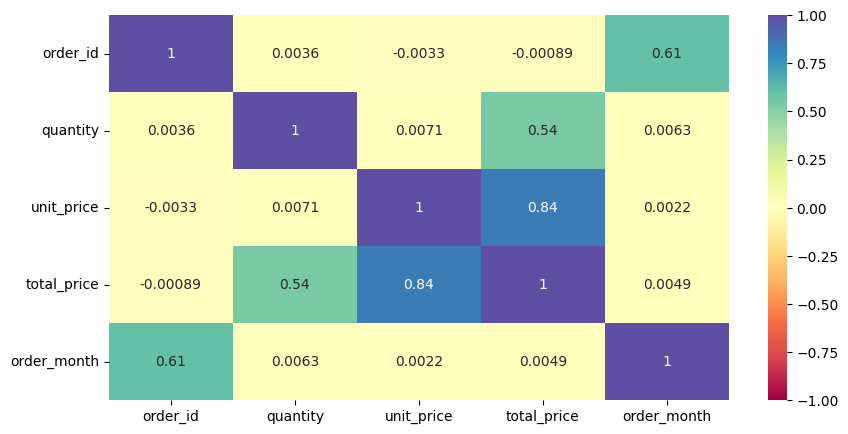

In [33]:
plt.figure(figsize=(10,5))
sns.heatmap(df[['order_id','quantity','unit_price','total_price','order_month']].corr(),annot=True,cmap='Spectral',vmin=-1,vmax=1)
plt.show()

1. The order month has a positive correlation of 0.61 with order_id.
2. The total price has a positive correlation with the quantity with a value of 0.54. The highest correlation is between total_price and unit_price with 0.84.
3. There are not negative correlation between the variables.
4. Variable which represent "ID" are drop from this heatmap because are only identifier.

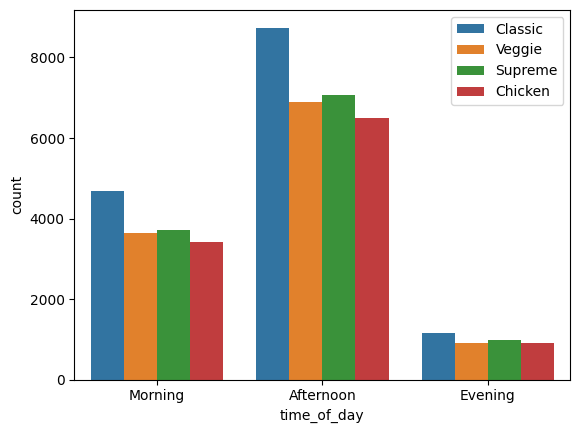

In [34]:
sns.countplot(data=df, x='time_of_day', hue="pizza_category")     
plt.legend(bbox_to_anchor=(1,1));

1. Most of the order are being delivered on Afternoon, being the principal of them Classic category. Then the amount of pizza delivered are being sold on Morning and the rest of them on evening.

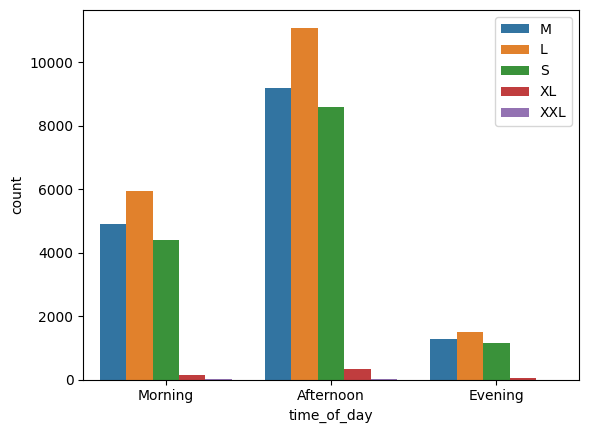

In [35]:
sns.countplot(data=df, x='time_of_day', hue="pizza_size")   #display the plot which shows demand of pizza size across the time of the day 
plt.legend(bbox_to_anchor=(1,1));

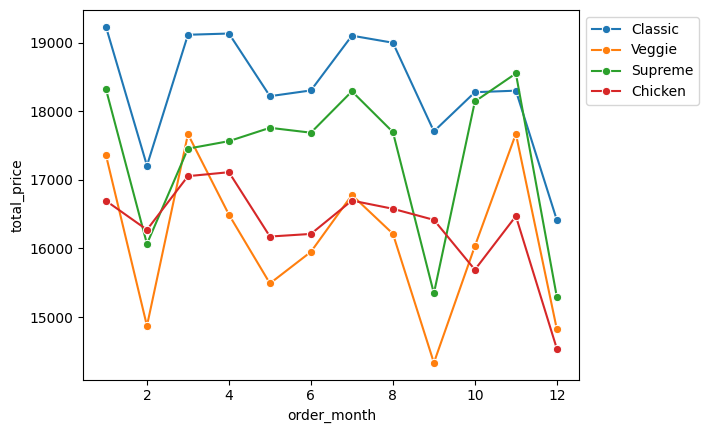

In [36]:
sns.lineplot(data=df, x="order_month", y="total_price", hue="pizza_category", estimator='sum', errorbar=None, marker="o")   #write the appropriate plot which can show the trend over the months  
plt.legend(bbox_to_anchor=(1,1));

There is a decrease on sales on month of February, September and December for every kind of pizzas. January is the month with highest sales of Pizzas.

## **Data Preprocessing**

In [37]:
# Create a directory called "project_scripts" for the preprocessing script
import os

src_dir_job_scripts = "./azure"
os.makedirs(src_dir_job_scripts, exist_ok=True)

### **Create Preprocessing Script**

In [38]:
%%writefile {src_dir_job_scripts}/pre_process.py

import argparse
import pandas as pd
from pathlib import Path

if __name__ == "__main__":

    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--output", type=str, help="path to output data")
    args = parser.parse_args()

    # Read the input data from the specified path
    df = pd.read_csv(args.data)
    df = df.drop_duplicates()
    df = df.dropna()
    
    # Transform Time format
    df['order_date']  = pd.to_datetime(df['order_date'], format='mixed', errors='coerce')
    df['order_time'] = pd.to_datetime(df['order_date'].astype(str)+' '+df['order_time'].astype(str))
    df.drop('order_date',axis=1,inplace=True)

    # Extract useful features from the date column
    df['order_month'] = df['order_time'].dt.month

    def category_day(x):
        if 0 < x <= 6:
            return 'Evening'
        elif 6 < x <= 13:
            return 'Morning'
        elif 13 < x <= 20:
            return 'Afternoon'
        else:
            return 'Evening'

    df['time_of_day'] = df['order_time'].dt.hour.apply(category_day)

    # Define output paths
    output_data_store = args.output
    preprocessed_data_output_path = Path(output_data_store, "processed_data.csv")

    # Save the processed data
    df.to_csv(preprocessed_data_output_path, index=False)

Overwriting ./azure/pre_process.py


### **Creating Preprocessing Job**

Write a code snippet to define a data preparation step for a pizza analysis project using a command function. The step should read a CSV input, process and transform the data, with inputs and outputs specified as uri_folder. Include a description, display name, and the command to execute a Python script for data preprocessing. Use a specified environment for execution

In [39]:
from azure.ai.ml import Input, Output
from azure.ai.ml import command

datastore_path = ml_client.data.get("pizza-data-sales", version="3").path

# Define a data preparation step
step_process_pre_process = command(
    name="pizza-data-sales",  # Name of the step
    display_name="Data preparation for Pizza Sales Analysis",  # Display name of the step
    description="Process and transform pizza sales data for analysis",  # Description
    inputs={
        "data": Input(type="uri_folder")  # Input dataset of type "uri_folder"
    },
    outputs=dict(processed_data=Output(type="uri_folder", mode="rw_mount")),  # Output
    # Source folder of the component
    code='./azure',  # Directory containing the preprocessing script
    command="python pre_process.py --data ${{inputs.data}} --output ${{outputs.processed_data}}",
    environment=env_docker_conda,  # Environment to use
)

## **Reporting via Dashboard**

### **Creating Files for the Dashboard**

#### Creating Directory

In [40]:
# Create a directory called project_files for storing the dashboard files
import os

src_dir_hf_space = "./files"
os.makedirs(src_dir_hf_space, exist_ok=True)

#### Creating Dashboard Script

In [43]:
%%writefile {src_dir_hf_space}/app.py
import streamlit as st
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load data
def load_data():
    df = pd.read_csv("processed_data.csv")  # replace with your dataset
    return df

# Create Streamlit app
def app():
    # Title for the app
    st.title("Pizza Sales Data Analysis Dashboard")
    df = load_data()

    df = pd.DataFrame(df)

    # Calculate key metrics
    total_unique_order = df['order_id'].nunique()
    total_revenue_generated = round(df['total_price'].sum(),0)
    most_popular_size = df['pizza_size'].value_counts().idxmax()
    most_freq_category = df['pizza_category'].value_counts().idxmax()
    total_pizzas_sold = int(df['quantity'].sum())

    # Sidebar with key metrics
    st.sidebar.header("Key Metrics")
    st.sidebar.metric("Total Orders:", total_unique_order)
    st.sidebar.metric("Total Pizzas sold:", total_pizzas_sold)
    st.sidebar.metric("Total Revenue generated:", f"${total_revenue_generated:.0f}")
    st.sidebar.metric("Most Popular pizza size:", most_popular_size)
    st.sidebar.metric("Most frequent category:", most_freq_category)

    plots = [
        {"title": "Top Selling Pizzas (by Quantity)", "x": "pizza_name", "y": "quantity", "top": 5}, 
        {"title": "Quantity of Pizzas Sold by Category and Time of the Day", "x": "pizza_category", "hue": "time_of_day"},  
        {"title": "Quantity of Pizzas Sold by Size and Time of the Day", "x": "pizza_size", "hue": "time_of_day"},  
        {"title": "Monthly Revenue Trends by Pizza Category", "x": "order_month", "y": "total_price", "hue": "pizza_category", "estimator": "sum", "marker": "o"}, 
    ]

    for plot in plots:
      st.header(plot["title"])
      
      fig, ax = plt.subplots()
      
      if "Top Selling Pizzas" in plot["title"]:
        data_aux = df.groupby(plot["x"])[plot["y"]].sum().reset_index().sort_values(by=plot["y"], ascending=False).head(plot["top"])
        ax.bar(data_aux[plot["x"]].values.tolist(), data_aux[plot["y"]].values.tolist())
        plt.xticks(rotation = 60)
      
      if "Quantity of Pizzas" in plot["title"]:
        sns.countplot(data=df, x=plot["x"], hue=plot["hue"], ax=ax)
      
      if "Monthly Revenue" in plot["title"]:
        sns.lineplot(data=df, x=plot["x"], y=plot["y"], hue=plot["hue"], estimator=plot["estimator"], errorbar=None, marker=plot["marker"], ax=ax)

      ax.set_xlabel(" ".join(plot["x"].split("_")).capitalize())
      if "y" in plot.keys():
        ax.set_ylabel(" ".join(plot["y"].split("_")).capitalize())
      else:
        ax.set_ylabel("Quantity")
      ax.legend(bbox_to_anchor=(1,1))

      st.pyplot(fig)

if __name__ == "__main__":
    app()

Overwriting ./files/app.py


#### Creating Requirements File

In [44]:
%%writefile {src_dir_hf_space}/requirements.txt
pandas==1.5.2
matplotlib==3.6.2
seaborn==0.12.1
scipy==1.10.0
numpy==1.23.5

Overwriting ./files/requirements.txt


#### Creating Script to Push Files to Hugging Face Space

In [ ]:
%%writefile {src_dir_job_scripts}/hugging_face_auth_push_files.py
from huggingface_hub import login, HfApi
from datasets import Dataset
import argparse
import os 
import pandas as pd

os.makedirs("./outputs", exist_ok=True) # Create the "outputs" directory if it doesn't exist

def select_first_file(path):
    """Selects first file in folder, use under assumption there is only one file in folder
    Args:
        path (str): path to directory or file to choose
    Returns:
        str: full path of selected file
    """
    files = os.listdir(path)
    return os.path.join(path, files[0])

def main():
    parser = argparse.ArgumentParser()

    # Provide the input arguments for these job
    parser.add_argument("--processed_data_push", type=str, help="path to processed data")
    parser.add_argument("--streamlit_files", type=str, help="path to streamlit files")
    args = parser.parse_args()
    
    
    hf_token = "#########"  # Your Hugging Face token
    repo_id = "Juanjose\###########"  # Your Hugging Face space id for the Project Week 6

    # Login to Hugging Face platform with the access token
    login(token=hf_token)

    # Initialize the API 
    api = HfApi()

    # Upload Streamlit app files (like app.py and requirements.txt) stored in the folder called streamlit_files
    api.upload_folder(
        folder_path=args.streamlit_files,  # Local folder path in azureml
        repo_id=repo_id,  # Hugging face space id
        repo_type="space",  # Hugging face repo type "space"
    )

    # Upload the processed data (processed_data.csv) to Hugging Face
    api.upload_file(
        path_or_fileobj=select_first_file(args.processed_data_push),
        path_in_repo="processed_data.csv",
        repo_id=repo_id,
        repo_type="space",
    )


if __name__ == '__main__':
    main()

Overwriting ./azure/hugging_face_auth_push_files.py


### **Creating Dashboard Reporting Job**

Write a code to define a Hugging Face authentication step for a dashboard project using a command function. The step should authenticate to the Hugging Face hub and push specified files. It should include inputs for the path to the processed data and a folder containing Streamlit files, along with the command to execute a Python script for authentication and file upload. Specify the source folder for the component and the environment for execution.

In [46]:
step_hugging_auth = command(
    name="hugging_face_authentication_dashboard",
    display_name="hugging face authentication and push files for Pizza Sales Analysis",
    description="Authenticate and push files to the HF hub for Pizza Sales Analysis",
    inputs={
        "processed_data_push": Input(type="uri_file"),  # The processed pizza sales data file
        "streamlit_files": Input(type="uri_folder"),  # Streamlit app files like app.py, requirements.txt
    },
    code='./azure',  # Location where the code is stored
    command="python hugging_face_auth_push_files.py \
     --processed_data_push ${{inputs.processed_data_push}} \
     --streamlit_files ${{inputs.streamlit_files}}",
    environment=env_docker_conda,  # Docker environment for the job
)

## **Reporting via Email**

### **Creating Email Report Script**

In [ ]:
%%writefile {src_dir_job_scripts}/daily_email_report.py
import argparse
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import pandas as pd
import os


os.makedirs("./outputs", exist_ok=True) # Create the "outputs" directory if it doesn't exist


def select_first_file(path):
    files = os.listdir(path)
    return os.path.join(path, files[0])


email_config = {
    "sender_email": "juanjo.astudilloe@gmail.com",
    "receiver_emails": "juanjo.astudilloe@gmail.com",
    "password": "#################",   # Note: Refer to the app password content page to get the password
    "smtp_server": "##############",
    "smtp_port": ###########
}

def main():

    parser = argparse.ArgumentParser()
    parser.add_argument("--processed_data", type=str, help="path to processed data")
    args = parser.parse_args()
    df = pd.read_csv(select_first_file(args.processed_data))  # Read the processed data

    # Calculate the top 5 metrics
    total_unique_order = df['order_id'].nunique()
    total_revenue_generated = round(df['total_price'].sum(),2)
    most_popular_size = df['pizza_size'].value_counts().idxmax()
    most_freq_category = df['pizza_category'].value_counts().idxmax()
    total_pizzas_sold = int(df['quantity'].sum())

    # Create a report dictionary for summary
    report = {
        "Total Orders": total_unique_order,
        "Total Pizzas Sold": total_pizzas_sold,
        "Total Revenue Generated": total_revenue_generated,
        "Most Popular Pizza Size": most_popular_size,
        "Most Frequent Category": most_freq_category
    }

    # Create email content
    def create_email_content(report):
        email_content = f"""
        <p>Dear Team,</p>
        <p>Please find below the summary of the Key metrics of Pizza Sales data.:</p>
        
        <ul>
            <li><strong>Total Orders:</strong> {report['Total Orders']}</li>
            <li><strong>Total Pizzas Sold:</strong> {report['Total Pizzas Sold']}</li>
            <li><strong>Total Revenue Generated:</strong> ${report['Total Revenue Generated']}</li>
            <li><strong>Most Popular Pizza Size:</strong> {report['Most Popular Pizza Size']}</li>
            <li><strong>Most Frequent Category:</strong> {report['Most Frequent Category']}</li>
        </ul>

        <p>Regards,<br>Juan José</p>
        """
        return email_content

    # Send email report
    def send_email_report(email_config, report_metrics):
        email_content = create_email_content(report_metrics)

        server = smtplib.SMTP(email_config['smtp_server'], email_config['smtp_port'])
        server.starttls()
        server.login(email_config['sender_email'], email_config['password'])

        msg = MIMEMultipart()  # Create new MIMEMultipart object for each recipient
        msg['From'] = email_config['sender_email']
        msg['To'] = email_config['receiver_emails']
        msg['Subject'] = 'Pizza Sales Analysis Report'
        msg.attach(MIMEText(email_content, 'html'))

        text = msg.as_string()
        server.sendmail(email_config['sender_email'], email_config['receiver_emails'], text)
        print(f"Email report sent to {email_config['receiver_emails']} successfully!")

        server.quit()

    # Call the function to send email report
    send_email_report(email_config, report)

if __name__ == '__main__':
    main()

Overwriting ./azure/daily_email_report.py


### **Creating Email Reporting Job**

Write a code to define a step for sending report emails based on processed pizza order data. The step should include inputs for the processed data (as a URI folder), a clear name and display name, and a description of its functionality. Specify the source folder for the component and the command to execute a Python script that generates and sends the email report. Use the designated environment for execution.

In [49]:
step_process_report = command(
    name="email_report_pizza_sales",
    display_name="Pizza Sales Report Email",
    description="Read the processed pizza sales data, compute metrics, and send the report via email.",
    inputs={
        "processed_data": Input(type="uri_folder"),
    },
    code='./azure', 
    command="python daily_email_report.py --processed_data ${{inputs.processed_data}}",  ##Calling daily_email_report.py
    environment=env_docker_conda, 
)

## **Building an Analytical Pipeline**

### **Assembling all Jobs into a Single Pipeline**

Write a code snippet to define an Azure ML pipeline for the Intelligent Reporting Project. The pipeline should include three steps: 

1. A data preparation job that processes an input CSV file (pizza_sales.csv).
2. A job for Hugging Face authentication and pushing files, taking the processed data from the first job and specified Streamlit files as inputs.
3. An email report job that sends a report based on the processed data from the first job.

Ensure that the pipeline has appropriate input parameters and returns a dictionary of outputs with identifiers for each step.

In [50]:
# Write your code here
from azure.ai.ml import command, Input, Output, dsl 

@dsl.pipeline(
    compute='test-cluster',  # Compute cluster definition
    description="Pizza Sales Analysis Reporting Pipeline"
)
def pizza_sales_pipeline(pipeline_job_data_input, hugging_face_folders):
    
    # Job 1: Data preparation job (Inputs: Pizza_Sales_Dataset.csv)
    data_prep_job = step_process_pre_process(data=pipeline_job_data_input)

    # Job 2: Hugging Face authentication and push files job (Inputs: processed_data.csv[job 1 output], streamlit files)
    hugging_face_job = step_hugging_auth(
        processed_data_push=data_prep_job.outputs.processed_data,
        streamlit_files=hugging_face_folders
    )

    # Job 3: Email report job (Inputs: processed_data.csv[job 1 output])
    email_report_job = step_process_report(
        processed_data=data_prep_job.outputs.processed_data
    )

    # The pipeline returns a dictionary of outputs
    return {"pipeline_job_prep_data": data_prep_job.outputs.processed_data}

### **Providing Paths for the Jobs**


Write a code snippet to instantiate the defined Azure ML pipeline by providing the necessary input parameters. The pipeline should take the input path for the pizza sales data as a URI file and a URI folder for the Hugging Face files, ensuring that both inputs are correctly specified for execution

In [51]:
# Write your code here
# Assemble the pipeline
pipeline = pizza_sales_pipeline(
    pipeline_job_data_input=Input(type="uri_file", path=datastore_path),  # Input path
    hugging_face_folders=Input(type="uri_folder", path="files/")  # Path for Streamlit files
)

### **Executing the Pipeline**

Write a code snippet to create or update a job in Azure ML using the defined pipeline. The job should be associated with a specified experiment name, such as "Project 1 - Intelligent Reporting on Azure ML Pipeline," and utilize the previously instantiated pipeline for execution.

In [52]:
# Write your code here
# Submit the pipeline job
pipeline_job = ml_client.jobs.create_or_update(
    pipeline,
    experiment_name="Project Definitive - Intelligent Reporting on Azure ML Pipeline"
)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading files (0.0 MBs): 100%|██████

## **Sample Output**

1. Conclusions and Recommendations
2. Hugging face space link and screenshot of dashboarding
3. Email report screenshot 

**CONCLUSIONS AND RECOMMENDATIONS**

- The amount of order received on the year are 21350 wich represent a total 49574 pizzas sold.
- The is a revenue generated of selling pizzas equal to $817860.
- The most purchased category is Classic and size L.
- There is no presence of a favorite pizza over the others, with similar quantities sold.
- The preferred time for consumers to buy pizza is in the afternoon, regardless of the category of pizza.
- S, M, L pizzas are more attractive to consumers, however, very few people choose to buy XL or XXL
- There are periods in which the demand for pizza consumption generally decreases, especially in the months of February, September and December.




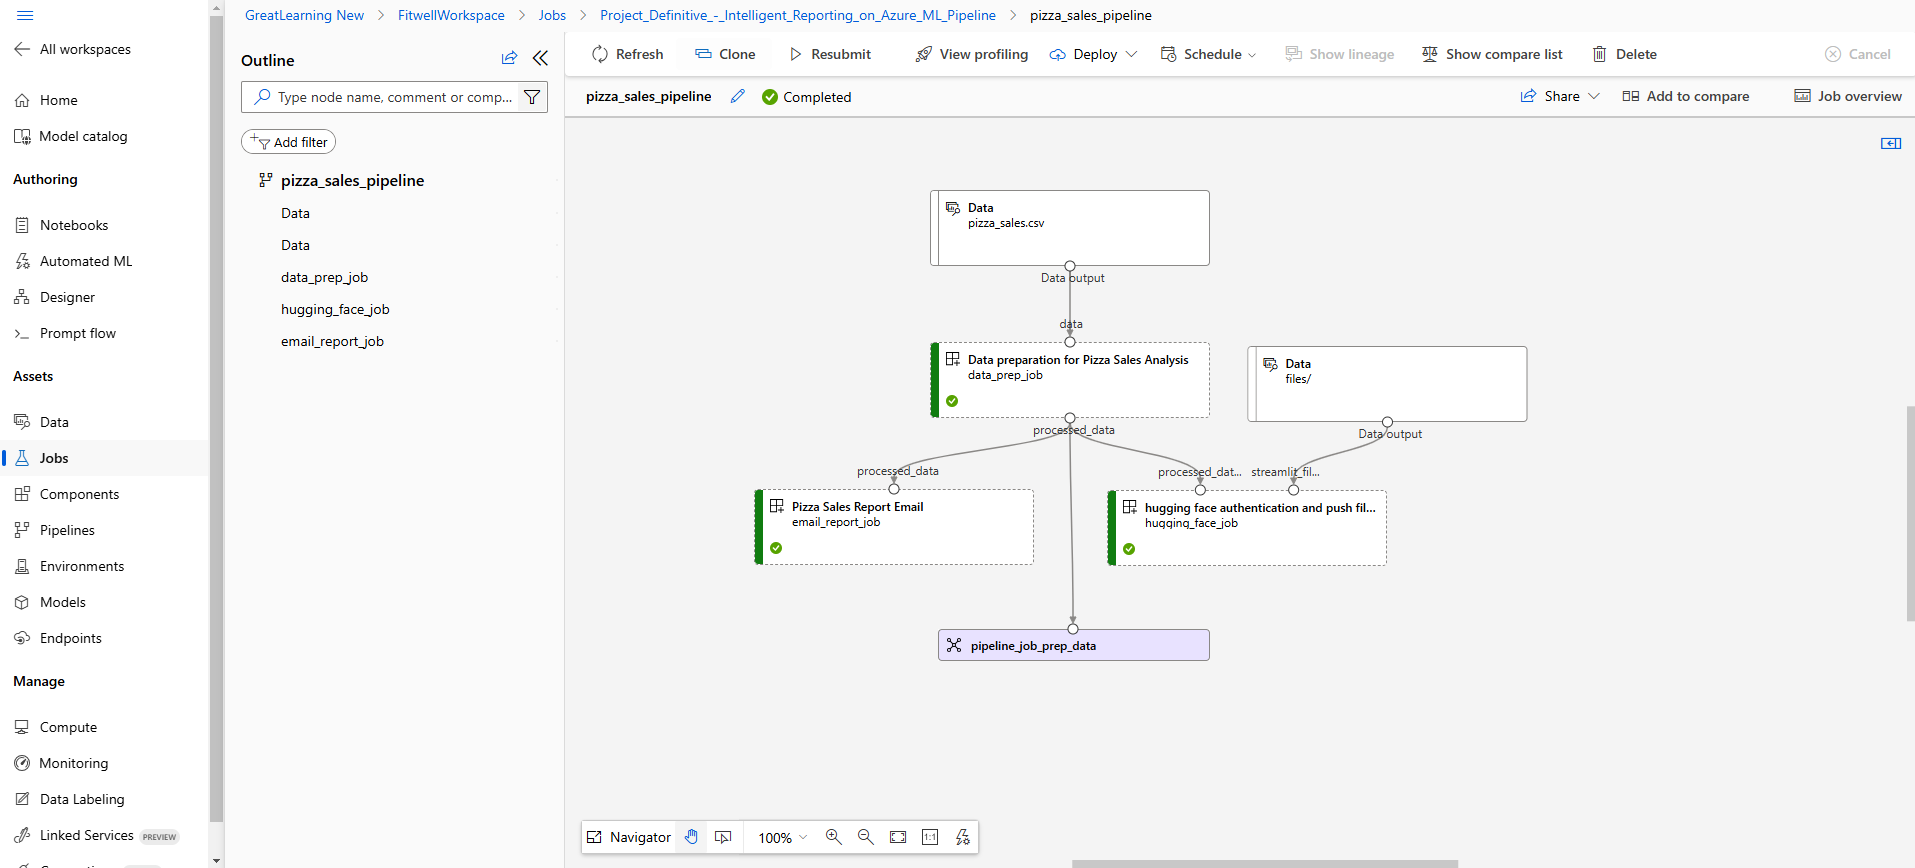

In [ ]:
from IPython import display
display.Image("figures/Completed_Pipeline.png")

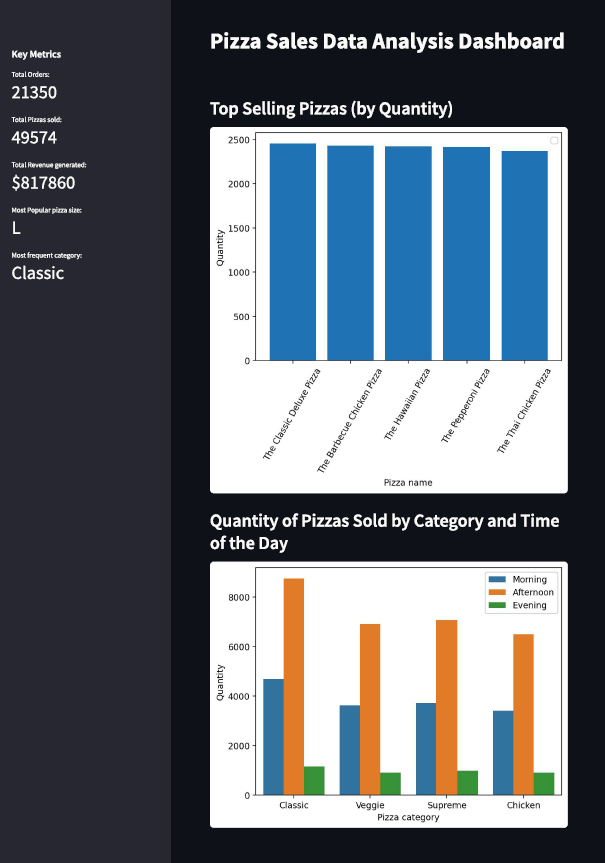

In [ ]:
from IPython import display
display.Image("figures/Dashboard_1.png")

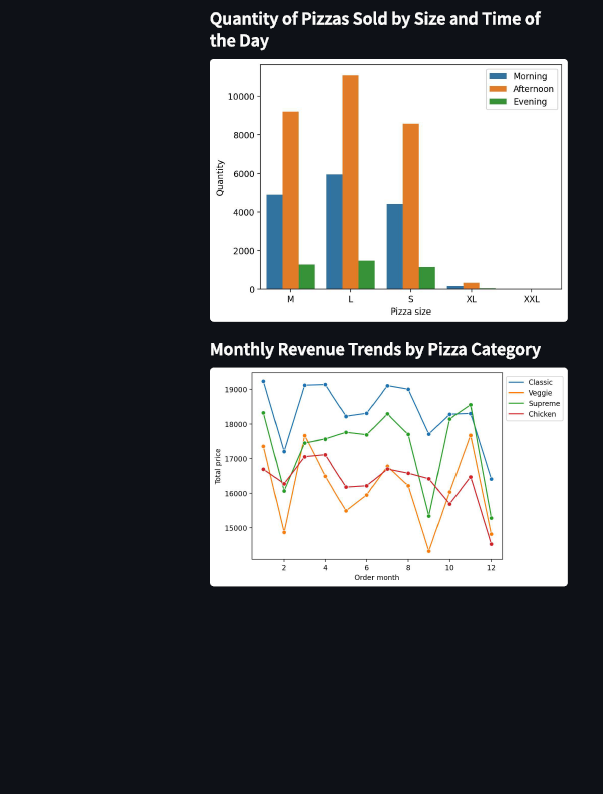

In [ ]:
from IPython import display
display.Image("figures/Dashboard_2.png")

**ACCESS TO HUGGING FACE SPACE:** https://juanjose90-projectweek6.hf.space/?embed=true&embed_options=show_toolbar#pizza-sales-data-analysis-dashboard

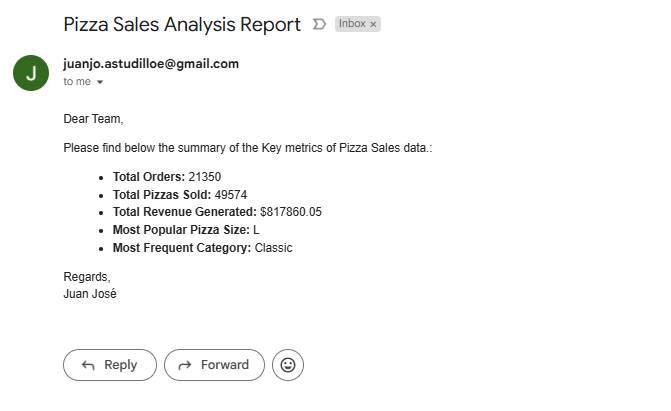

In [ ]:
from IPython import display
display.Image("figures/email_sent.png")

##### Thanks, Juan Jose.